In [193]:
import pandas as pd
import numpy as np
import matplotlib as ml
import re
import nltk

nltk.download('all')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [383]:
'''
This dataset aggregates tweets pertaining to climate change collected 
between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were annotated. 
Each tweet is labelled independently by 3 reviewers. 
This dataset only contains tweets that all 3 reviewers agreed on (the rest were discarded).

Each tweet is labelled as one of the following classes:

    2(News): the tweet links to factual news about climate change
    1(Pro): the tweet supports the belief of man-made climate change
    0(Neutral: the tweet neither supports nor refutes the belief of man-made climate change
    -1(Anti): the tweet does not believe in man-made climate change

'''

data = pd.read_csv("./twitter_sentiment_data.csv")
data[:5]

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [384]:
'''
data statistics:
0. remove chars not in 0-9,a-z,A-Z  [done]
1. total tweets. [done]
2. sentiment -
    a. tweets per sentiment [done]
    b. top-n words occuring per sentiment [done]
3. #tags - 
    a. top-n used function [done]
    b. total distinct tags used [done]
4. @therate -
    a. top-n used function [done]
    b. total distinct @therate used [done] 
    
    
data analysis:
0. partition the data set into train & test. (not using verify here.)[done]
1. create word vector of top-100 words used. [done]
2. train ml models on that word vector only. [done]
'''

print("Let's begin!")

Let's begin!


In [385]:
class DataCleaner:
    def remove_no_chars(self, text):
        return re.sub(r'[^a-zA-Z0-9@#]+',' ', text)
    
    def remove_links(self, text):
        return re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    
    def to_lower(self, text):
        return text.lower()
    
    def remove_stopwords(self, text):
        text = text.split()
        return ' '.join([word for word in text if word not in stopwords.words('english')])
    
    def lemmatize(self, text):
        text = text.split()
        return ' '.join([lemmatizer.lemmatize(word) for word in text])
    
class Pipeline:
    def pipe(self, *funcs):
        self.funcs = funcs
    
    def call(self, text):
        for func in self.funcs:
            text = func(text)
        return text

In [386]:
class Utility:
    def __init__(self):
        pass
    
    def sort_dict(self, wordmap):
        keys = list(wordmap.keys())
        values = list(wordmap.values())
        sorted_value_index = np.argsort(values)[::-1] #reversing the list here.
        sorted_wordmap = {keys[i]: values[i] for i in sorted_value_index}
        return sorted_wordmap

class Stats:
    def __init__(self, data):
        self._data = data #underscore makes it a private member
        self._util = Utility()
        
        cleaner = DataCleaner()
        pipeline = Pipeline()
        pipeline.pipe( cleaner.remove_links, cleaner.remove_no_chars, cleaner.to_lower,
                      cleaner.remove_stopwords, cleaner.lemmatize)
        
        self._data.message = self._data.message.apply(pipeline.call)
        self._sentiments = set(self._data.sentiment)
        
    def plot_tweets_per_sentiment(self):
        self._data.sentiment.value_counts().plot(kind='barh')
        print("Total tweets:", len(self._data))
        
    def get_wordmap_by_condition(self, condition):
        def count_words(text, senti): #inner func to use s2w_map as global-external variable
            for word in text.split(' '):
                if condition(word): #condition-lambda
                    if word in s2w_map[senti]:
                        s2w_map[senti][word] += 1
                    else:
                        s2w_map[senti][word] = 1
        
        s2w_map = {} #dict of dicts.
        for i in self._sentiments:
            s2w_map[i] = {}
            
        self._data.apply(lambda x: count_words(x.message, x.sentiment), axis=1)
        
        for i in self._sentiments:
            s2w_map[i] = self._util.sort_dict(s2w_map[i])
        return s2w_map
        
    def get_topN_words_per_sentiment(self, topN):
        y = self.get_wordmap_by_condition(lambda x: len(x) > 4) #word length > 4
        for i in self._sentiments:
            print(i, "\n", list(y[i].items())[:min(topN, len(y[i].items()))])
            print("*******************")
        
    def get_topN_tags_per_sentiment(self, topN):
        y = self.get_wordmap_by_condition(lambda x: '#' in x and len(x) > 1) #word length > 4
        for i in self._sentiments:
            print(i, "\n", list(y[i].items())[:min(topN, len(y[i].items()))])
            print("*******************")
    
    def get_topN_atTheRates_per_sentiment(self, topN):
        y = self.get_wordmap_by_condition(lambda x: '@' in x and len(x) > 1) #word length > 4
        for i in self._sentiments:
            print(i, "\n", list(y[i].items())[:min(topN, len(y[i].items()))])
            print("*******************")
        
    def get_data(self):
        return self._data


In [387]:
stat = Stats(data)

Total tweets: 43943


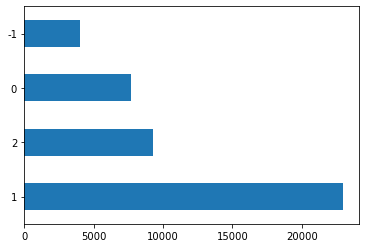

In [388]:
stat.plot_tweets_per_sentiment()

In [330]:
stat.get_topN_atTheRates_per_sentiment(10)

0 
 [('@realdonaldtrump', 84), ('@cnn', 32), ('@civiljustus', 32), ('@youtube', 28), ('@ultravlolence', 23), ('@foxnews', 20), ('@potus', 20), ('@nytimes', 19), ('@kurteichenwald', 18), ('@jay', 18)]
*******************
1 
 [('@stephenschlegel', 507), ('@sensanders', 445), ('@realdonaldtrump', 377), ('@leodicaprio', 255), ('@berniesanders', 245), ('@natgeochannel', 219), ('@sethmacfarlane', 139), ('@climatecentral', 112), ('@climatereality', 111), ('@cnn', 110)]
*******************
2 
 [('@thehill', 213), ('@nytimes', 113), ('@cnn', 105), ('@reuters', 105), ('@independent', 92), ('@guardian', 88), ('@washingtonpost', 88), ('@guardianeco', 63), ('@worldfnature', 62), ('@sciam', 55)]
*******************
-1 
 [('@realdonaldtrump', 173), ('@stevesgoddard', 135), ('@tan123', 41), ('@prisonplanet', 36), ('@algore', 35), ('@junkscience', 31), ('@foxnews', 31), ('@climatedepot', 26), ('@carbongate', 24), ('@sensanders', 24)]
*******************


In [331]:
stat.get_topN_tags_per_sentiment(10)

0 
 [('#climate', 59), ('#climatechange', 52), ('#trump', 20), ('#globalwarming', 18), ('#debatenight', 16), ('#cop21', 14), ('#auspol', 14), ('#cop22', 12), ('#science', 9), ('#qanda', 9)]
*******************
1 
 [('#climate', 547), ('#climatechange', 399), ('#beforetheflood', 268), ('#actonclimate', 157), ('#parisagreement', 108), ('#cop22', 98), ('#imvotingbecause', 93), ('#auspol', 76), ('#globalwarming', 74), ('#trump', 72)]
*******************
2 
 [('#climate', 333), ('#climatechange', 177), ('#news', 81), ('#environment', 78), ('#trump', 50), ('#science', 42), ('#globalwarming', 32), ('#cop22', 27), ('#p2', 22), ('#cop21', 21)]
*******************
-1 
 [('#tcot', 65), ('#maga', 31), ('#climate', 27), ('#climatechange', 25), ('#pjnet', 23), ('#trump', 21), ('#globalwarming', 19), ('#fakenews', 15), ('#p2', 13), ('#teaparty', 11)]
*******************


In [332]:
stat.get_topN_words_per_sentiment(10)

0 
 [('climate', 4601), ('change', 4572), ('global', 3240), ('warming', 3147), ('about', 941), ('trump', 459), ('believe', 227), ('think', 207), ('people', 204), ('there', 193)]
*******************
1 
 [('change', 19389), ('climate', 19278), ('global', 4295), ('warming', 3932), ('about', 2873), ('trump', 2283), ('believe', 1927), ('doesn', 1435), ('world', 1186), ('people', 1140)]
*******************
2 
 [('change', 8188), ('climate', 8106), ('trump', 2037), ('global', 1414), ('warming', 1232), ('scientists', 481), ('fight', 399), ('study', 397), ('about', 393), ('world', 370)]
*******************
-1 
 [('climate', 2382), ('change', 2255), ('global', 1972), ('warming', 1912), ('about', 421), ('science', 191), ('obama', 186), ('there', 184), ('@realdonaldtrump', 173), ('people', 168)]
*******************


In [389]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

class MachineLearn:
    def __init__(self, data):
        self.X = data['message']
        self.y = data['sentiment']
        
    def split_data(self, ratio): #ratio = 0.30
        self.X_train, self.X_test, self.y_train, self.y_test = \
        train_test_split(self.X, self.y, test_size=ratio, random_state=123)
        
        print('Training Data :', self.X_train.shape)
        print('Testing Data : ', self.X_test.shape)
        
    def extract_feature(self, X, kind='count'):
        if kind == 'count':
            self.transformer = CountVectorizer()
            tranformed_data = self.transformer.fit_transform(X)
            return tranformed_data
        
        if kind == 'tfidf':
            self.transformer = TfidfVectorizer()
            tranformed_data = self.transformer.fit_transform(X)
            return tranformed_data
        
    def applyModel(self, ratio = 0.30, model_type='lr', kind='count'):
        #split into train-test.
        self.split_data(ratio)
        
        #transform train and test.
        Xtrain = self.extract_feature(self.X_train, kind)
        Xtest = self.transformer.transform(self.X_test)
        
        #apply model
        if model_type == 'lr':
            model = LogisticRegression()
        if model_type == 'rf':
            model = RandomForestRegressor(n_estimators = 100, max_depth=5, random_state = 0)
        
        #fit train data
        model.fit(Xtrain, self.y_train)
        self.ypred = model.predict(Xtest)
        
        print("Model:", model_type)
        
        if model_type == 'lr':
            print(classification_report(self.y_test, self.ypred))
            print("Accuracy score: ", accuracy_score(self.y_test,  self.ypred))

In [390]:
machineLearning = MachineLearn(data)
machineLearning.applyModel(model_type='rf')

Training Data : (30760,)
Testing Data :  (13183,)
Model: rf
